In [215]:
# install required system dependencies
# !apt-get install -y xvfb x11-utils 
# !apt-get install x11-utils > /dev/null 2>&1
# !pip install PyVirtualDisplay==2.0.* \
#   PyOpenGL==3.1.* \
#   PyOpenGL-accelerate==3.1.* \
#   gym[box2d]==0.17.* 
# !pip install pyglet

In [216]:
from google.colab import drive
import sys
drive.mount('/content/drive')
# drive.flush_and_unmount()
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/Reinforcement')

import world
from world import World

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [217]:
import gym
import numpy as np
import base64
import io
import IPython

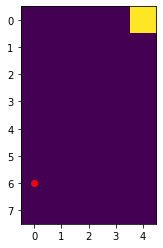

<Figure size 432x288 with 0 Axes>

In [218]:
import random

#Map information
grid = [8, 5]
dirt = [[0, 0, 0, 0, 10],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]
moves = 1000
pos = [6, 0]
terminal = [[0, 4]]

# Random setting
seed = 1  
random.seed(seed)


#Env load
env = World(pos, moves, grid, dirt, terminal)
obs = env.reset()
env.render()

In [219]:
import operator
def policy_action(model, si , sj, epsilon = 0.1): 
    if random.random() > epsilon:
        Q = {}
        actions = env._action_space()
        for a in range(len(actions)):
          value = model.predict(si, sj, a)
          Q[a] = value
        result = max(Q.items(), key=operator.itemgetter(1))
        return result[0], result[1]
    else:
        return random.randrange(len(env._action_space())), 0

In [220]:
class Function:
  def __init__(self, env):
    self._w = np.zeros((env.grid_size[0], env.grid_size[1], len(env._action_space())))
    self._z = np.zeros((env.grid_size[0], env.grid_size[1], len(env._action_space())))

  def predict(self, si, sj, a):
    return self._w[si][sj][a]

  def grad(self, si, sj, a):
    # grad_v_hat = np.zeros_like(self._z)
    # grad_v_hat[state] = 1
    return 1

In [221]:
def semi_gradient_sarsa(env, func, alpha=0.3, gamma=1.0):
    rewards = []
    for i_episode in range(20000):
        cumu_reward = 0
        if i_episode % 1000 == 0:
          print("episode:", i_episode)

        #Initial state and action of episode

        actions = env._action_space()
        env.reset()
        Si, Sj = env.position
        A, _ = policy_action(func, Si, Sj)
   
        # Loop for each step of the episode until 𝑆 = Terminal :
        while True:
            old_w = model._w.copy()

            #Take action 𝐴, observe 𝑅, new S'
            _, R, done, _ = env.step(actions[A])
            cumu_reward += R


            # if 𝑆 = Terminal
            if done:
                target = R
                delta = target - func.predict(Si, Sj, A)
                func._w[Si][Sj][A] += alpha * delta * func.grad(Si, Sj, A)
                break

            # New S'
            Si_, Sj_ = env.position
            A_, _ = policy_action(func, Si_, Sj_)

            target =  R + gamma * func.predict(Si_, Sj_, A_)
            delta = target - func.predict(Si, Sj, A)
            func._w[Si][Sj][A] += alpha * delta * func.grad(Si, Sj, A)
            Si, Sj, A = Si_, Sj_, A_
        
        rewards.append(cumu_reward)
    return rewards

In [222]:
env.reset()
func1 = Function(env)
reward1 = semi_gradient_sarsa(env, func1)

episode: 0
episode: 1000
episode: 2000
episode: 3000
episode: 4000
episode: 5000
episode: 6000
episode: 7000
episode: 8000
episode: 9000
episode: 10000
episode: 11000
episode: 12000
episode: 13000
episode: 14000
episode: 15000
episode: 16000
episode: 17000
episode: 18000
episode: 19000


In [223]:
def opt_policy(env, policy):
    policy_max = np.max(policy, axis=2)
    # print(policy_max)
    y = np.linspace(env.grid_size[0] - 1, 0, env.grid_size[0]) + 0.5
    x = np.linspace(0, env.grid_size[1] - 1, env.grid_size[1]) + 0.5
    X, Y = np.meshgrid(x, y)
    zeros = np.zeros((env.grid_size))
    
    fig = plt.figure(figsize=(12,8))
    ax = plt.axes()
    
    for i_action, action in enumerate(env._action_space()):
        policy_star = np.zeros((env.grid_size[0], env.grid_size[1]))
        for i in reversed(range(env.grid_size[0])):
            for j in reversed(range(env.grid_size[1])):
                if policy[i, j, i_action] == policy_max[i, j]:
                # if policy[i, j, i_action] != 0:
                    policy_star[i, j] = 0.4

        #Plot results
        if action == "U":
            # Vectors point in positive Y-direction
            plt.quiver(X, Y, zeros, policy_star, scale=1, units='xy')
        elif action == "L":
            # Vectors point in negative X-direction
            plt.quiver(X, Y, -policy_star, zeros, scale=1, units='xy')
        elif action == "D":
            # Vectors point in negative Y-direction
            plt.quiver(X, Y, zeros, -policy_star, scale=1, units='xy')
        elif action == "R":
            # Vectors point in positive X-direction
            plt.quiver(X, Y, policy_star, zeros, scale=1, units='xy')
        
    plt.xlim([0, env.grid_size[1]])
    plt.ylim([0, env.grid_size[0]])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.grid()
    plt.show()

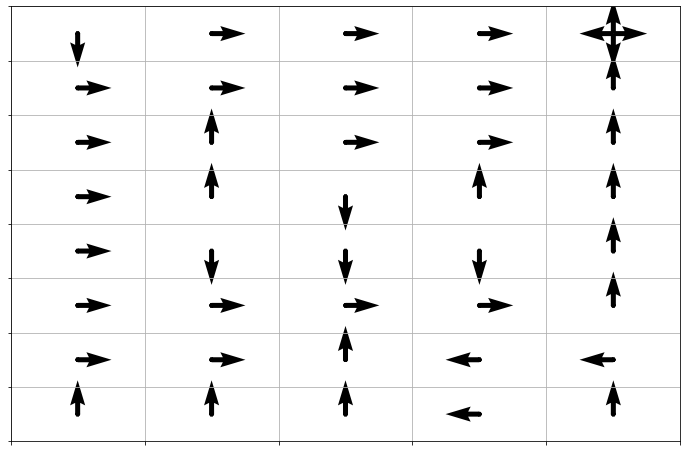

In [224]:
import matplotlib.pyplot as plt
opt_policy(env, func._w)

In [225]:
def update_z(func, si, sj, action, method='accumulating', lmda = 1, gamma = 1):
    # x(s) = s
    func._z = func._z * lmda * gamma
    if (method == 'replace'):
        func._z[si][sj][action] = 1
    elif method == 'accumulating':
        func._z[si][sj][action] += 1
    return 

In [226]:
def sarsa_linear_function(env, func, alpha=0.3, gamma=1.0, lmda=0.2):
    rewards = []
    for i_episode in range(20000):
        cumu_reward = 0
        if i_episode % 1000 == 0:
          print("episode:", i_episode)

        #Initial state and action of episode

        actions = env._action_space()
        env.reset()
        Si, Sj = env.position
        A, _ = policy_action(func, Si, Sj)

        func._z = np.zeros_like(func._w)
   
        # Loop for each step of the episode until 𝑆 = Terminal :
        while True:
            old_w = model._w.copy()

            #Take action 𝐴, observe 𝑅, new S'
            _, R, done, _ = env.step(actions[A])
            cumu_reward += R

            delta = R
            delta -=  func.predict(Si, Sj, A)

            update_z(func, Si, Sj, A, gamma=gamma, lmda=lmda)

            # if 𝑆 = Terminal
            if done:
                func._w[Si][Sj][A] += alpha * delta * func._z[Si][Sj][A]
                break

            # New S', new A'
            Si_, Sj_ = env.position
            A_, _ = policy_action(func, Si_, Sj_)

            delta += gamma * func.predict(Si_, Sj_, A_)
            func._w[Si][Sj][A] += alpha * delta * func._z[Si][Sj][A]
            Si, Sj, A = Si_, Sj_, A_
        rewards.append(cumu_reward)
    return rewards

In [227]:
env.reset()
func2 = Function(env)
reward2 = sarsa_linear_function(env, func2)

episode: 0
episode: 1000
episode: 2000
episode: 3000
episode: 4000
episode: 5000
episode: 6000
episode: 7000
episode: 8000
episode: 9000
episode: 10000
episode: 11000
episode: 12000
episode: 13000
episode: 14000
episode: 15000
episode: 16000
episode: 17000
episode: 18000
episode: 19000


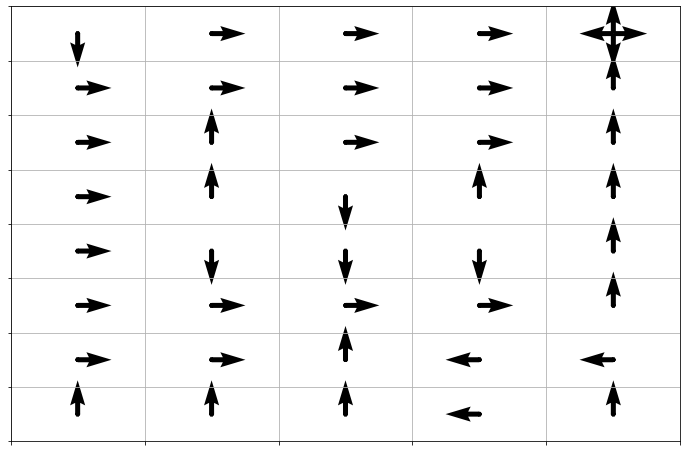

In [228]:
import matplotlib.pyplot as plt
opt_policy(env, func._w)

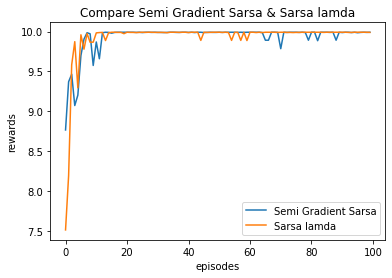

In [237]:
import matplotlib.pyplot as plt
plt.plot(reward1[:100], label = "Semi Gradient Sarsa")
plt.plot(reward2[:100], label = "Sarsa lamda")
plt.xlabel('episodes')
plt.ylabel('rewards')
plt.title('Compare Semi Gradient Sarsa & Sarsa lamda')

plt.legend()

plt.show()

In [234]:
print('Semi: ', np.mean(reward1))
print('Lambda: ', np.mean(reward2))

Semi:  9.95138595
Lambda:  9.9651059
